In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

In [ ]:
#READ EXPRESSION MATRIX AND EUCLIDEAN DISTANCE MATRIX
ed = pd.read_csv('matrix-1-euclidean-correlation.csv', index_col =0)
exp = pd.read_csv('matrix-5-Expression.csv', index_col = 0)

In [ ]:
eud = ed
eu = ed

FINDING MATURE - IMMATURE PAIR OF ORs 

In [ ]:
#MAKE A LIST OF ALL ORS AND CELLS AND TRANSPOSE THE EXP MATRIX
ors=list(exp.columns.values.tolist())
cells=exp.index.values
tr_exp=exp.T

In [ ]:
#CHECK IF THE CELL EXPRESSES MORE THAN 8 ORS THEN APPEND THE CELL ID 
all_ors={}
zero_exp=[]
for cell in cells:
  all_ors[cell]=[]
  cell_exps=sorted(tr_exp[cell].tolist(), reverse=True)
  if cell_exps[0]>0:
    if tr_exp[cell].tolist().count(max(cell_exps)) > 8:
      for i in range(tr_exp[cell].tolist().count(max(tr_exp[cell]))):
        all_ors[cell].append(tr_exp.sort_values(by=cell, ascending=False).index[i])
    else:
      for i in range(8):
        if cell_exps[i]>0:
          all_ors[cell].append(tr_exp.sort_values(by=cell, ascending=False).index[i])
  else:
    zero_exp.append(cell)

In [ ]:
#INDIVIDUALLY MAKE A DICTIONARY FOR EACH CELL TYPE WHERE THE CELL ID AND THE EXPRESSED OR IS STORED
cell_imt={}
cell_imm={}
cell_mat={}
for key,value in all_ors.items():
  if key.startswith("IMT"):
    cell_imt[key]=[]
    for val in value:
      if val.startswith("Olfm"):
        continue
      else:
        cell_imt[key].append(val)
  if key.startswith("MA"):
    cell_mat[key]=[]
    for val in value:
      if val.startswith("Olfm"):
        continue
      else:
        cell_mat[key].append(val)
  if key.startswith("IMM"):
    for val in value:
      cell_imm[key]=[]
      if val.startswith("Olfm"):
        continue
      else:
        cell_imm[key].append(val)


In [ ]:
#TO TREAT IMMATURE AND TRANSITION AS ONE, MERGE THE DICTIONARY
cell_imm_imt={}
for key,value in all_ors.items():
  if key.startswith("IM"):
    cell_imm_imt[key]=[]
    for val in value:
      if val.startswith("Olfm"):
        continue
      else:
        cell_imm_imt[key].append(val)

In [ ]:
#CHECK IF THERE IS NO EXPRESSION OF OR, MAKE A NEW DICTIONARY WITH ONLY EXPRESSED ORs
di1={}
for key,value in cell_imm_imt.items():
  di2={}
  if len(value)<1:
    continue
  else:
    for val in value:
      di2[val]=tr_exp[key][val]
    di1[key]=di2

READING PERCENTILE FILES AND INTERSECTION

In [ ]:
#GENERATE UNIQUE HITS
ratio_data={}
unique_number = {}
unique_percentage = {}
di='test_'+str(1)
os.mkdir(di)
os.chdir(di) 
#A FILE IS GENERATED WITH ALL INFORMATION OF mOSN, iOSN/tOSN, THE EUCLIDEAN DISTANCE AND OR EXPRESSED
with open("Out_data_eud_"+str(1)+".csv","w")as fout:
    fout.write("Olfactory Receptor,Mature Cell ID,Immature/Transition Cell ID, ED,Dist. Rank,Receptor Expression Rank,Receptor Expression,Expression Diffrence from rank1\n")
    empty_mat=[]
    mat_cell=eud.index
    imm_imt_cells=list(eud.columns.values.tolist())
    for i in range(len(mat_cell)):
        mat1={}
        for j in range(len(imm_imt_cells)):
            mat1[eud.iloc[i][j]]=imm_imt_cells[j]
        euds=sorted(mat1.keys(), reverse=False)
        for j in range(len(euds)):
            if len(cell_mat[mat_cell[i]])==0:
                empty_mat.append(mat_cell[i])
            else:
                if cell_mat[mat_cell[i]][0] in cell_imm_imt[mat1[euds[j]]]:
                    for k in range(len(cell_imm_imt[mat1[euds[j]]])):
                        if cell_imm_imt[mat1[euds[j]]][k]==cell_mat[mat_cell[i]][0]:
                            #print(cell_imm_imt[mat1[euds[j]]][k],mat_cell[i],mat1[euds[j]],euds[j],k,di1[mat1[euds[j]]][cell_imm_imt[mat1[euds[j]]][k]])
                            fout.write(str(cell_imm_imt[mat1[euds[j]]][k])+','+str(mat_cell[i])+','+str(mat1[euds[j]])+','+str(euds[j])+','+str(j)+','+str(k)+','+str(di1[mat1[euds[j]]][cell_imm_imt[mat1[euds[j]]][k]])+','+str((di1[mat1[euds[j]]][cell_imm_imt[mat1[euds[j]]][0]])-di1[mat1[euds[j]]][cell_imm_imt[mat1[euds[j]]][k]])+'\n')

#CALCULATING PERCENTILE AT DIFFERENT THRESHOLD FOR EUC DISTANCE
eu = eud
li = [0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.5]
for ki in li:
    q = eu.quantile(ki , axis = 1)
    q1 = q.tolist()
    qq = pd.DataFrame(q)

    idd = eu.index.tolist()
    ccl = eu.columns.tolist()
    d4=dict.fromkeys(idd)

    #loop to generate imm cells
    k = []
    for i in range(len(idd)):
        for j in range(len(ccl)):
            if eu.iloc[i][j] < q1[i]:
                k.append(ccl[j])
        d4[idd[i]] = k
        k=[]

    p = []
    for i in idd:
        p.append(len(d4[i]))
    cells = pd.DataFrame.from_dict(d4, orient='index')
    cells.to_csv(str(ki)+'percentile_euc_total_immature.csv')


#ASSIGNING THE STATUS POSITIVE AND NEGATIVE ON BASIS OF THE mOSN THAT LIE IN THAT PARTICULAR THRESHOLD
for ki in li:
    p=pd.read_csv(str(ki)+'percentile_euc_total_immature.csv', index_col = 0)
    o = pd.read_csv('Out_data_eud_'+str(1)+'.csv')
    dictt={}
    v =  o['Mature Cell ID'].tolist()
    v2 = o['Immature/Transition Cell ID'].tolist()
    for indx in range(len(v)):
        if v[indx]==v[indx-1]:
            dictt[v[indx]].append(v2[indx])
        else:
            dictt[v[indx]]=[]
            dictt[v[indx]].append(v2[indx])
    ke=[]
    for key in dictt:
        ke.append(key)
    pp = p.loc[ke].T
    ppp = pp.to_dict('list')
    dup = pd.read_csv('Out_data_eud_'+str(1)+'.csv')
    stat=[]
    for i in range(0,len(dup['Immature/Transition Cell ID'])):
        if dup['Immature/Transition Cell ID'][i] in ppp[dup['Mature Cell ID'][i]]:
            stat.append('Positive')
        else:
            stat.append('Negative')

    dup['status'] = stat
    #dup.to_csv('Final_spl_10q.csv')
    dup.to_csv(str(ki)+'percentile_neg_pos_out_data.csv')
    



In [ ]:
li = [0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.5]
valss_unique=[]
for ki in li:
    percntile_dat=pd.read_csv(str(ki)+'percentile_neg_pos_out_data.csv')
    res1=pd.DataFrame()
    for mat in list(set(percntile_dat['Mature Cell ID'].tolist())):
        res1=res1.append(percntile_dat[percntile_dat['Mature Cell ID']==mat].sort_values(by=' ED', ascending=True).drop_duplicates(subset = 'Mature Cell ID', keep = 'first'))
    #print(len(res1[(res1['status']=='Positive') & (res1['Expression Diffrence from rank1']==0)]))
    valss_unique.append(len(res1[(res1['status']=='Positive') & (res1['Expression Diffrence from rank1']==0)]))
    res1[(res1['status']=='Positive') & (res1['Expression Diffrence from rank1']==0)].to_csv(str(ki)+'percentile_unique_out_data.csv')

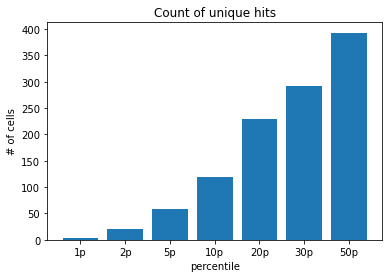

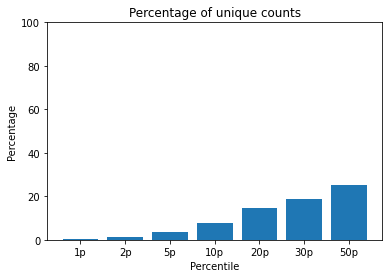

In [ ]:
#PLOT OF NUMBER OF UNIQUE mOSNs 

unique_number[str(1)]=valss_unique

gra = pd.DataFrame(valss_unique)
gra.to_csv('unique-count.csv')


x = ['1p', '2p', '5p', '10p', '20p', '30p', '50p']
plt.bar(x,valss_unique)
plt.title('Count of unique hits')
plt.xlabel('percentile')
plt.ylabel('# of cells')
plt.savefig('number of unique hits euclidean.pdf')
plt.show()


#PERCENTAGE OF UNIQUE mOSNs
valssf=[]
for v in valss_unique:
    valssf.append((v/1559)*100) #1559 is the number of total unique mOSNs having atleast some expression of an specific OR

unique_percentage[str(1)]=valssf


gra = pd.DataFrame(valssf)
gra.to_csv('unique-percentage.csv')


plt.bar(x,valssf)
plt.title('Percentage of unique counts')
plt.xlabel('Percentile')
plt.ylabel('Percentage')
plt.savefig('percentage')
plt.yticks([0, 10, 20, 30, 40, 50])
plt.savefig('percentage_normalised_hits.pdf')
plt.show()

In [ ]:
#SAVE UNIQUE PERCENTAGE OF HIT 
data_frame = pd.DataFrame.from_dict(unique_percentage, orient = 'columns')
data_frame.to_csv('chi-square-unique percentage-euc-test.csv')

In [ ]:
#SAVE UNIQUE HIT
data_frame = pd.DataFrame.from_dict(unique_number, orient = 'columns')
data_frame.to_csv('chi-square-unique count-euc-test.csv')